## Setup

In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.models import Model

import copy as cp

In [25]:
def load_data(test=False):
    X_raw = Y_raw = None
    segment = False

    if test:
        X_raw = np.load("../emulator/hc_test_G3.npy", allow_pickle=True)
        Y_raw = np.load("../emulator/samples_test_G3.npy", allow_pickle=True)
    else:
        X_raw = np.load("../emulator/hc_G3_redo.npy", allow_pickle=True)
        Y_raw = np.load("../emulator/samples_G3_redo.npy", allow_pickle=True)
    
    scales = np.load("../emulator/standard_k.npy", allow_pickle=True)
    
    return scales, X_raw, Y_raw

In [8]:
def eliminate_holes(X_raw, Y_raw):
    def is_bad(row):
        if float('-inf') in row or float('inf') in row \
            or None in row or True in np.isnan(pspec) \
            or 0 in row:
            return True
        return False

    bad_row_indices = []
    for i in range(len(Y_raw)):
        pspec = Y_raw[i]
        if is_bad(pspec):
            bad_row_indices.append(i)

    X = np.delete(X_raw, bad_row_indices, 0)
    Y = np.delete(Y_raw, bad_row_indices, 0)
    
    return X, Y

In [17]:
def normalize_data(Y):
    Ylog = np.log(Y)
    mu = np.mean(Ylog, axis=0)
    stdev = np.std(Ylog, axis=0)
    
    Y_normalized = cp.deepcopy(Ylog)

    for i in range(len(Y)):
        Y_normalized[i] -= mu
        Y_normalized[i] /= stdev
        
    return Y_normalized

In [2]:
def loadData(ns = 50, N_train = 70, N_test = 29, cov_len = 126):
    """
    Load the covariance matrices
    """

    name_root="samples2/ns50/xiell_cov_noisy_ns{}_".format(ns)
    train_data = np.zeros((N_train, cov_len, cov_len))
    test_data = np.zeros((N_test, cov_len, cov_len))
    for i in range(N_train):
        train_data[i] = np.loadtxt(name_root+"{:04d}.dat".format(i+1))
    for i in range(N_test):
        test_data[i] = np.loadtxt(name_root+"{:04d}.dat".format(N_train+i+1))
    
    return train_data, test_data
    

In [23]:
def preprocess_cov(array, theory_cov):
    cov_len = len(theory_cov)
    for i in range(cov_len):
        for j in range(cov_len):
            array[:, i, j] /= np.sqrt(theory_cov[i, i] * theory_cov[j, j])
    array = np.reshape(array, (len(array), cov_len, cov_len))
    return array

In [24]:
def preprocess_alpha(covs, theory_cov):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """
    covs_norm = []
    for cov in covs:
      theory_diag = np.diagonal(theory_cov)
      cov_ii = cov/np.sqrt(theory_diag)
      cov_jj = np.transpose(cov_ii)/np.sqrt(theory_diag)
      covs_norm.append(np.transpose(cov_jj))

    
    return np.array(covs_norm)

In [25]:
def preprocess_theory(theory_cov, N = 70):
    cov_len = len(theory_cov)
    array = np.zeros((N, cov_len, cov_len))
    for i in range(cov_len):
        for j in range(cov_len):
            array[:, i, j] = theory_cov[i, j] / np.sqrt(theory_cov[i, i] * theory_cov[j, j])
    array = np.reshape(array, (len(array), cov_len, cov_len, 1))
    return array

## Prepare the data

In [26]:
# Since we only need images from the dataset to encode and decode, we
# won't use the labels.
k, raw_train_x, raw_train_y = load_data(test=False)

# Normalize and reshape the data
consolidated_train_x, consolidated_train_y = \
    eliminate_holes(raw_train_x, raw_train_y)

normalized_train_y = normalize_data(consolidated_train_y)

k, raw_test_x, raw_test_y = load_data(test=True)

# Normalize and reshape the data
consolidated_test_x, consolidated_test_y = \
    eliminate_holes(raw_test_x, raw_test_y)

normalized_test_y = normalize_data(consolidated_test_y)

## Build the FCNN

In [32]:
input_layer = layers.Input(shape=(6))

# Encoder
#x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(input)
# x = layers.MaxPooling2D((3, 3), padding="same")(x)
#x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
# x = layers.MaxPooling2D((3, 3), padding="same")(x)

x = layers.Dense(64, activation='relu')(input_layer)
x = layers.Dense(300, activation='softmax')(x)

# Decoder
#x = layers.Conv2DTranspose(32, (3, 3), strides=1, activation="relu", padding="same")(x)
#x = layers.Conv2DTranspose(64, (3, 3), strides=1, activation="relu", padding="same")(x)
#x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Emulator
emu = Model(input_layer, x)
emu.compile(optimizer="adam", loss="mean_squared_error")
emu.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 6)]               0         
                                                                 
 dense_10 (Dense)            (None, 64)                448       
                                                                 
 dense_11 (Dense)            (None, 300)               19500     
                                                                 
Total params: 19,948
Trainable params: 19,948
Non-trainable params: 0
_________________________________________________________________


## Training and testing

In [49]:
emu.fit(
    x=consolidated_train_x,
    y=normalized_train_y,
    epochs=10,
    batch_size=32, # we've got to play around with this
    # values tested so far: 1
    shuffle=True,
    validation_data=(consolidated_test_x, normalized_test_y),
)
# predictions = emu.predict(test_data)

Epoch 1/10
157/157 [==============================] - 0s 3ms/step - loss: 0.9982 - val_loss: 0.9982
Epoch 2/10
157/157 [==============================] - 0s 3ms/step - loss: 0.9982 - val_loss: 0.9982
Epoch 3/10
157/157 [==============================] - 0s 3ms/step - loss: 0.9982 - val_loss: 0.9982
Epoch 4/10
157/157 [==============================] - 0s 3ms/step - loss: 0.9982 - val_loss: 0.9982
Epoch 5/10
157/157 [==============================] - 0s 2ms/step - loss: 0.9982 - val_loss: 0.9982
Epoch 6/10
157/157 [==============================] - 0s 2ms/step - loss: 0.9982 - val_loss: 0.9982
Epoch 7/10
157/157 [==============================] - 0s 2ms/step - loss: 0.9982 - val_loss: 0.9982
Epoch 8/10
157/157 [==============================] - 0s 2ms/step - loss: 0.9982 - val_loss: 0.9982
Epoch 9/10
157/157 [==============================] - 1s 4ms/step - loss: 0.9982 - val_loss: 0.9982
Epoch 10/10
157/157 [==============================] - 0s 3ms/step - loss: 0.9982 - val_loss: 0.9982

In [54]:
consolidated_train_x[0].shape

(6,)

In [56]:
first_prediction = emu.predict(consolidated_train_x[0])
plt.loglog(k, first_prediction)

TypeError: in user code:

    File "/home/lfinkbei/anaconda3/envs/camb/lib/python3.9/site-packages/keras/engine/training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "/home/lfinkbei/anaconda3/envs/camb/lib/python3.9/site-packages/keras/engine/training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/lfinkbei/anaconda3/envs/camb/lib/python3.9/site-packages/keras/engine/training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "/home/lfinkbei/anaconda3/envs/camb/lib/python3.9/site-packages/keras/engine/training.py", line 2111, in predict_step
        return self(x, training=False)
    File "/home/lfinkbei/anaconda3/envs/camb/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/lfinkbei/anaconda3/envs/camb/lib/python3.9/site-packages/keras/activations.py", line 83, in softmax
        if x.shape.rank > 1:

    TypeError: Exception encountered when calling layer 'dense_11' (type Dense).
    
    '>' not supported between instances of 'NoneType' and 'int'
    
    Call arguments received by layer 'dense_11' (type Dense):
      • inputs=tf.Tensor(shape=<unknown>, dtype=float32)


In [50]:
predictions = emu.predict(consolidated_test_x)

157/157 [==============================] - 0s 730us/step


In [51]:
predictions.shape

(5000, 300)

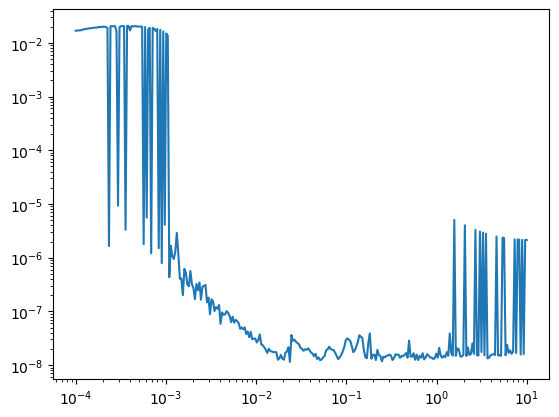

In [52]:
plt.loglog(k, predictions[0])